In [1]:
import sys
sys.path.insert(1, '/t0-analysis/CKA-similarity')

import numpy as np
from CKA import CKA

import matplotlib
import matplotlib.pyplot as plt

from utils import load_hidden_representations_from_hdf5, read_templates_from_file

In [2]:
# params
log_dir = "/logfiles"
model = "bigscience-T0_3B" # bigscience-T0_B or bigscience-T0
module = "decoder" # encoder or decoder
task = "rte"
# task = "cb"
# task = "wic"

## Prompts

In [3]:
df = read_templates_from_file(f"/t0-analysis/prompts/{task}/fixed_prompt.csv")
# df = read_templates_from_file(f"/t0-analysis/prompts/{task}/fixed_target_yes_no.csv")
display(df)

,name,template,category,includes_targets,targets,target_ids,shuffle
0,gpt_3_yes_no_with_targets,{premise} Question: {hypothesis} Yes or No?,instructive,True,"▁Yes, ▁No","0, 1",False
1,gpt_3_true_false_with_targets,{premise} Question: {hypothesis} True or False?,instructive,True,"▁True, ▁False","0, 1",False
2,gpt_3_cat_dog_with_targets,{premise} Question: {hypothesis} Cat or Dog?,instructive,True,"▁Cat, ▁Dog","0, 1",False
3,gpt_3_yes_no_without_targets,{premise} Question: {hypothesis}?,instructive,False,"▁Yes, ▁No","0, 1",False


## Comput CKA per prompt across layers

In [4]:
if task == 'rte':
    use_pattern = [
        "gpt_3_yes_no_with_targets",
        "gpt_3_true_false_with_targets",
        "gpt_3_cat_dog_with_targets",
        "gpt_3_yes_no_without_targets",
    ]
elif task == 'cb':
    use_pattern = [
        "null_pattern",
        "null_pattern_reversed",
        "gpt_3_true_false_neither",
        "gpt_3_yes_no_maybe",
        "mnli_crowdsource",
        "always_sometimes_never",
        "based_on_previous_passage",
        "infer",
        "claim",
        "consider",
        "follow",
        "imply",
        "guaranteed",
        "guaranteed_possible",
        "justified",
        "must_be_true",
        "should_assume",
        "take_the_following",
    ]
elif task == 'wic':
    use_pattern = [
        "gpt_3",
        "gpt_3_yes_no",
        "affirmation",
        "grammar_homework",
        "polysemous",
        "question_context",
        "question_meaning",
        "question_meaning_yes_no",
        "same_sense",
        "similar_sense",
        "similar_sense_yes_no",
    ]

In [5]:
representations = {}

for _, row in df.iterrows():
    prompt_name = row['name']

    if prompt_name in use_pattern:
        if prompt_name not in representations:
            representations[prompt_name] = {}

    for t in range(2):
        if t not in representations:
            representations[prompt_name][t] = {}
            
            for layer in range(0, 25):
                layer_key = f"{module}-{layer}"

                if layer_key not in representations[prompt_name][t]:
                    representations[prompt_name][t][layer_key] = {}

                file_name = f"{task}/{model}/{module}/{row['name']}/hidden_represenations_t{t}_layer{layer}_avg.hdf5"
                
                # load hidden representations from hdf5 file
                representations[prompt_name][t][layer_key] = load_hidden_representations_from_hdf5(os.path.join(log_dir, file_name), silent=True)

In [6]:
representations.keys()

dict_keys(['gpt_3_yes_no_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets', 'gpt_3_yes_no_without_targets'])

In [7]:
# Compute CKA for every pattern across layers
np_cka = CKA()

cka_scores_pattern = {}
for pattern in list(representations.keys())[:]:
    if pattern not in cka_scores_pattern:
        cka_scores_pattern[pattern] = {}
    for t in range(2):
        cka_scores = []
        for layer1 in representations[pattern][t].keys():
            cka_scores_layer1 = []
            for layer2 in representations[pattern][t].keys():
                cka_score = np_cka.linear_CKA(representations[pattern][t][layer1], representations[pattern][t][layer2])
                cka_scores_layer1.append(cka_score)
            cka_scores.append(cka_scores_layer1)
        cka_scores = np.asarray(cka_scores)
        cka_scores_pattern[pattern][t] = cka_scores

In [8]:
cka_scores_pattern['gpt_3_yes_no_with_targets'][0].shape

(25, 25)

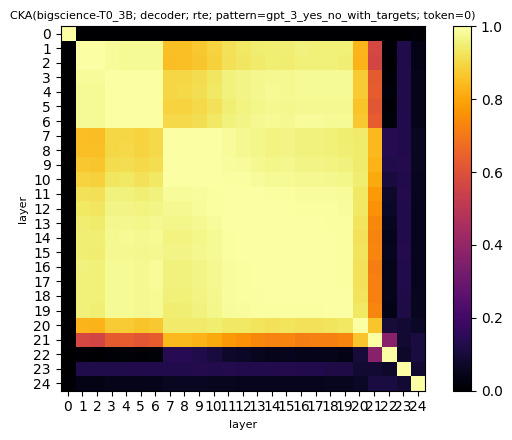

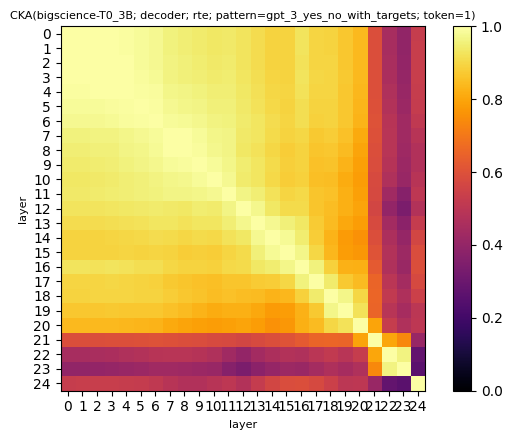

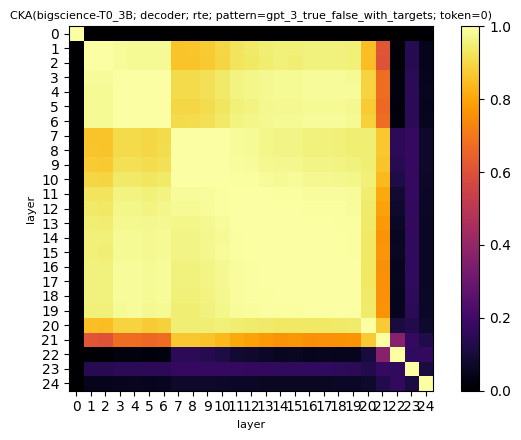

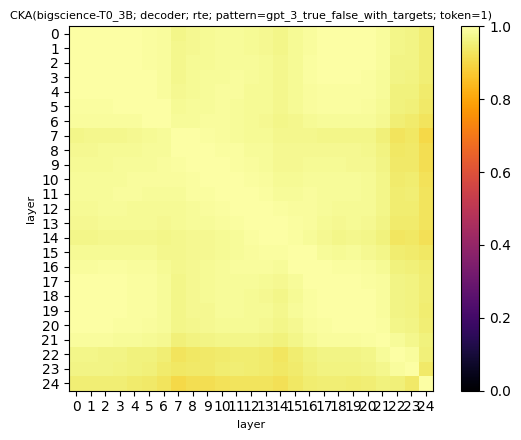

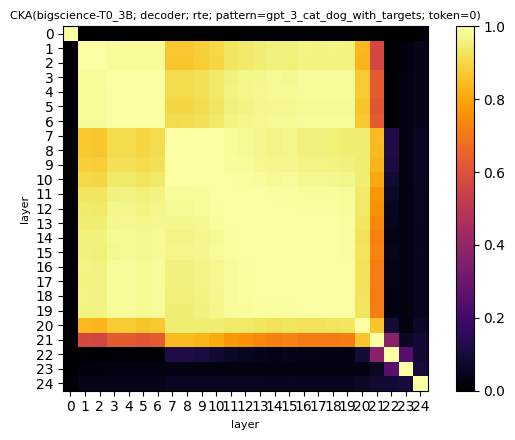

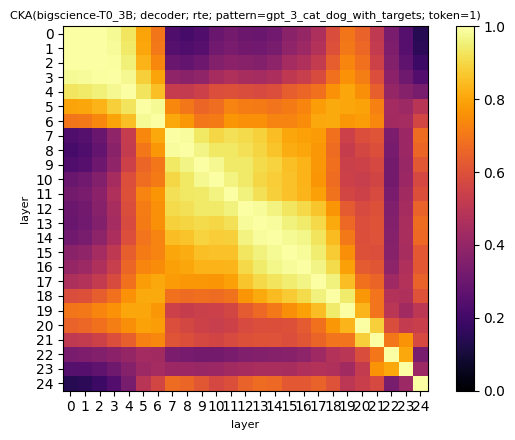

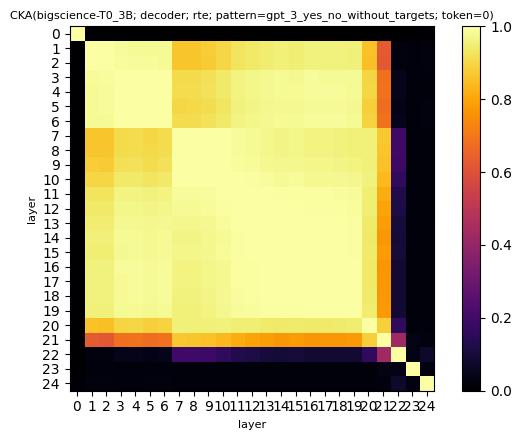

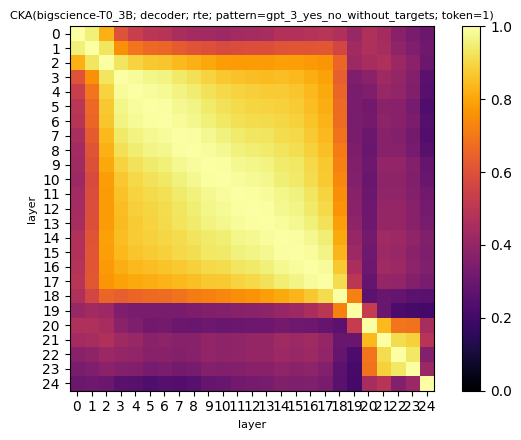

In [9]:
for pattern in list(cka_scores_pattern.keys())[:]:
    for t in range(2):
        values = cka_scores_pattern[pattern][t]

        fig, axes = plt.subplots(1, 1, figsize=(6.0,4.5), dpi=100)

        im = axes.imshow(values, cmap='inferno', vmin=0.0, vmax=1.0)
        # Create colorbar
        cbar = axes.figure.colorbar(im, ax=axes)
        cbar.ax.set_ylabel("", rotation=-90, va="bottom")

        axes.set_xlabel("layer", fontsize=8)
        axes.set_xticks(np.arange(len(values)))
        axes.set_ylabel("layer", fontsize=8)
        axes.set_yticks(np.arange(len(values)))

        axes.set_title(f"CKA({model}; {module}; {task}; pattern={pattern}; token={t})", fontsize=8)

        plt.tight_layout()
        plt.show()
        plt.close();


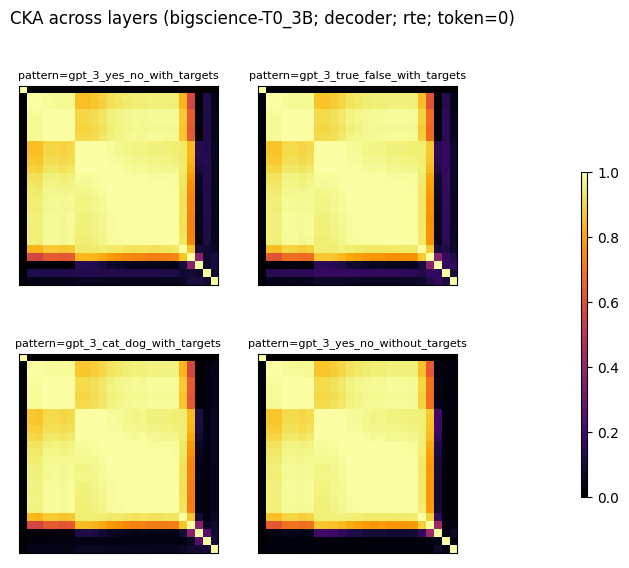

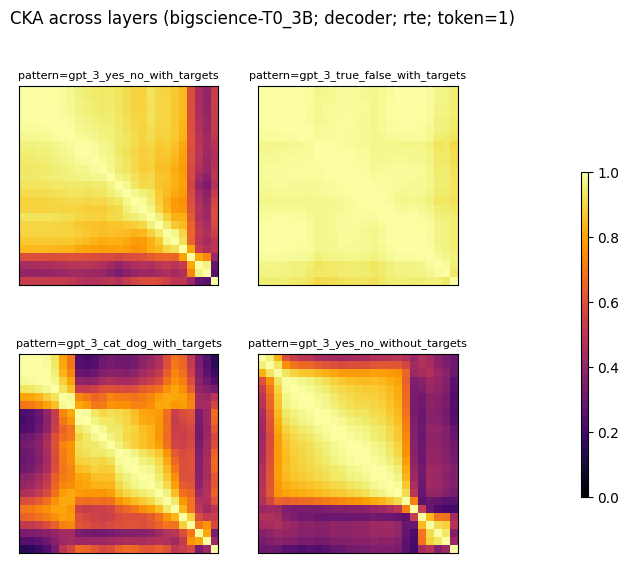

In [13]:
for t in range(2):
    plt.figure(figsize=(6.5, 6.5), dpi=100)

    for l, pattern in enumerate(cka_scores_pattern.keys()):
        values = cka_scores_pattern[pattern][t]

        plt.subplot(2, 2, l+1)
        axes = plt.gca()
        axes.get_xaxis().set_visible(False)
        axes.get_yaxis().set_visible(False)
        im = axes.imshow(values, cmap='inferno', vmin=0.0, vmax=1.0)
        # Create colorbar
        # cbar = axes.figure.colorbar(im, ax=axes)
        # cbar.ax.set_ylabel("", rotation=-90, va="bottom")

        axes.set_xlabel("template", fontsize=8)
        axes.set_xticks(np.arange(len(values)))
        axes.set_ylabel("template", fontsize=8)
        axes.set_yticks(np.arange(len(values)))

        # axes.set_title(f"Pairwise CKA ({model}; {module}; {task}; layer={layer})", fontsize=8)
        axes.set_title(f"pattern={pattern}", fontsize=8)

    # add colorbar
    fig = plt.gcf()
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.99, 0.23, 0.01, 0.5])
    fig.colorbar(im, cax=cbar_ax)

    plt.suptitle(f"CKA across layers ({model}; {module}; {task}; token={t})")
    # plt.tight_layout()
    plt.show()
    plt.close();

In [ ]:
df